## K-Means vs AHC (Agglomerative Hierachical Clustering)

In this notebook we'll compare the K-means and the HCA algorithms for clustering task on the data "Penguins Species" available [here](https://www.kaggle.com/datasets/youssefaboelwafa/clustering-penguins-species/data). For this task, we'll use directly the algorithm pre-implemented in the library `scikit-learn`. We will use `matplotlib` and `seaborn` for the visualization part.

### Installation & Setup

In [2]:
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install seaborn
!pip install scikit-learn

  Using cached matplotlib-3.8.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached contourpy-1.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.50.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (159 kB)
  Using cached kiwisolver-1.4.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
  Using cached pillow-10.2.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
Using cached matplotlib-3.8.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
Using cached contourpy-1.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (313 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.50.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.9 MB)
Usi

In [3]:
import os
import pandas as pd

df = pd.read_pickle(os.path.join('data', 'dataset.pkl'))

### EDA (Exploratory Data Analysis)

In [4]:
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


In [6]:
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,214.014620,4201.754386
std,5.459584,1.974793,260.558057,801.954536
min,32.100000,13.100000,-132.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.750000,4750.000000
max,59.600000,21.500000,5000.000000,6300.000000


The minimum of flipper length is negative. There is at least one negative value of this features which is not possible. Let's drop all lines with a negative flipper length?

In [7]:
df = df[~(df['flipper_length_mm'] < 0)]

According to the data description and the first values, it can exist very high values in the some flipper length. Let's check them and delete them.

In [8]:
df[df['flipper_length_mm'] > 300]

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
9,42.0,20.2,5000.0,4250.0,MALE


In [9]:
df = df[~(df['flipper_length_mm'] > 300)]

In [10]:
df['sex'].value_counts()

sex
MALE      167
FEMALE    165
.           1
Name: count, dtype: int64

In [11]:
df['sex'].value_counts()

sex
MALE      167
FEMALE    165
.           1
Name: count, dtype: int64

In [12]:
df.isna().sum()

culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
sex                  9
dtype: int64

### Feature Distribution

Text(0.5, 1.0, 'Body mass distribution')

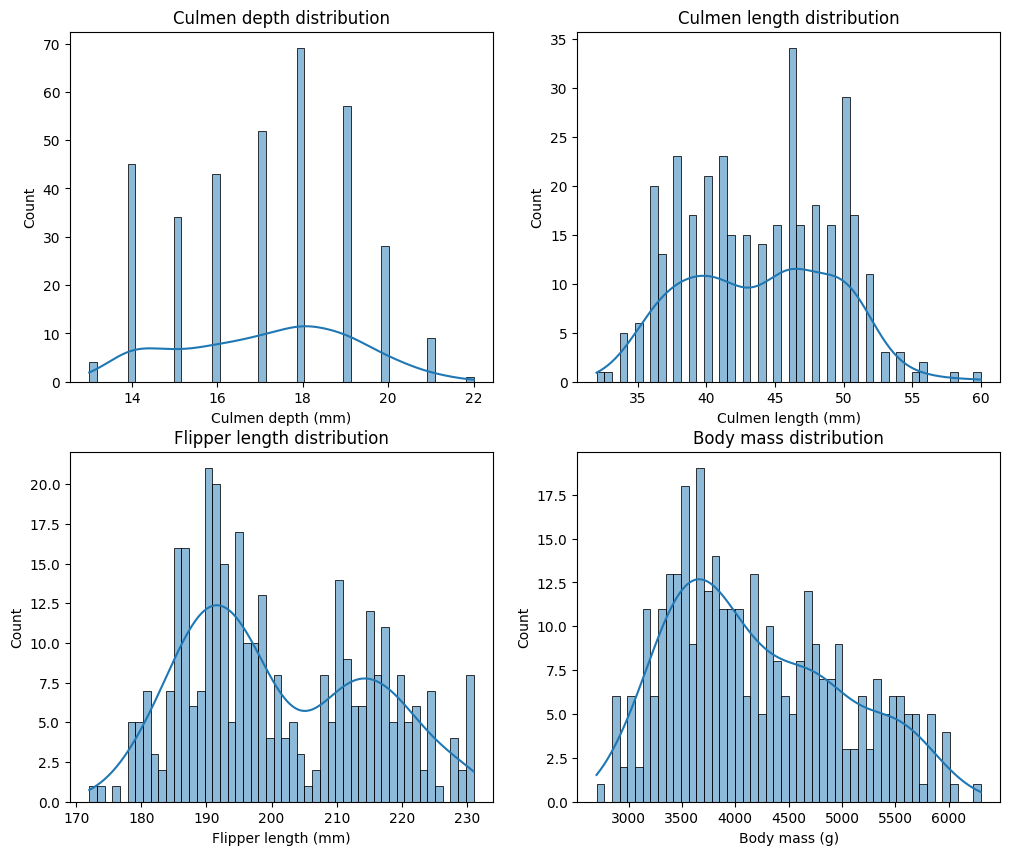

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.histplot(df, x='culmen_depth_mm', bins=50, kde=True)
plt.xlabel('Culmen depth (mm)')
plt.title('Culmen depth distribution')

plt.subplot(2, 2, 2)
sns.histplot(df, x='culmen_length_mm', bins=50, kde=True)
plt.xlabel('Culmen length (mm)')
plt.title('Culmen length distribution')

plt.subplot(2, 2, 3)
sns.histplot(df, x='flipper_length_mm', bins=50, kde=True)
plt.xlabel('Flipper length (mm)')
plt.title('Flipper length distribution')

plt.subplot(2, 2, 4)
sns.histplot(df, x='body_mass_g', bins=50, kde=True)
plt.xlabel('Body mass (g)')
plt.title('Body mass distribution')



### Feature Engineering

In [14]:
import numpy as np

df['sex'] = np.where(df['sex'] == 'MALE', 1, np.where(df['sex'] == 'FEMALE', 0, np.nan))

Using KNNInputer to manage missing values

In [15]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(np.round(imputer.fit_transform(df)), columns=df.columns)

In [16]:
df['sex'].value_counts()

sex
0.0    172
1.0    170
Name: count, dtype: int64

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(df)

In [18]:
X

array([[-0.9178255 ,  0.93555226, -1.42261512, -0.56329022,  1.00586515],
       [-0.73296312, -0.06745361, -1.06617968, -0.50084524, -0.99416905],
       [-0.73296312,  0.43404932, -0.4245959 , -1.18774001, -0.99416905],
       ...,
       [ 1.11566068, -0.56895655,  1.50015546,  1.93450891,  1.00586515],
       [ 0.19134878, -1.07045948,  0.78728459,  1.24761415, -0.99416905],
       [ 1.11566068, -0.56895655,  0.85857167,  1.49739406,  1.00586515]])

### PCA (Principal Component Analysis)

Now, let's create a function that allows to reduce features to 2D dimension using PCA so we can plot the graph !

In [19]:
from sklearn.decomposition import PCA

def reduce_to_2D(X):
    pca = PCA(n_components=2)
    return pca.fit_transform(X)

In [20]:
def draw2Dgraph(X_pca, labels, method_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', edgecolor='k')
    labels = [x for x in labels if x != -1]
    plt.title(f'{method_name} Clustering with {len(np.unique(labels))} Clusters (Reduced to 2D)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Cluster')
    plt.legend()
    plt.grid(True)
    plt.show()

In [21]:
def count_cluster_lengths(labels):
    unique, counts = np.unique(labels, return_counts=True)
    cluster_ids = [cluster_id + 1 if cluster_id != -1 else cluster_id for cluster_id in unique]
    cluster_lengths = {
        'Cluster': cluster_ids,
        'Count': counts
    }
    return cluster_lengths

### Clustering with K-Means

First, let's find the optimal number of clusters (k) using the elbow method.

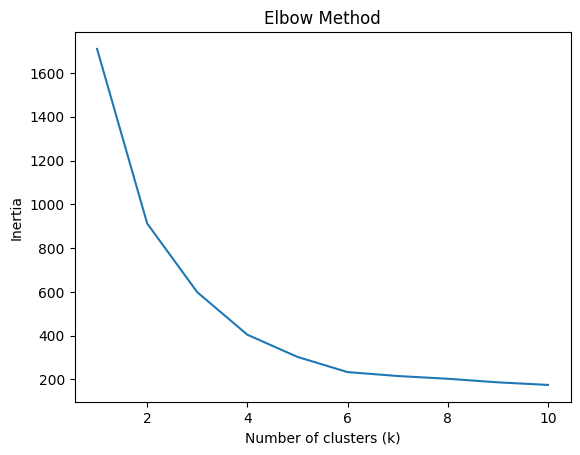

In [22]:
from sklearn.cluster import KMeans

inertia_values = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(X)
    inertia_values.append(kmeans.inertia_)
    
plt.plot(range(1, 11), inertia_values)
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()

According to the curve, we can assume that the optimal number of clusters k is 4.

In [23]:
kmeans = KMeans(n_clusters=4)
y_means = kmeans.fit_predict(X)

In [24]:
labels = kmeans.labels_
# centers = kmeans.cluster_centers_

In [25]:
count_cluster_lengths(labels)

{'Cluster': [1, 2, 3, 4], 'Count': array([111,  61, 108,  62])}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


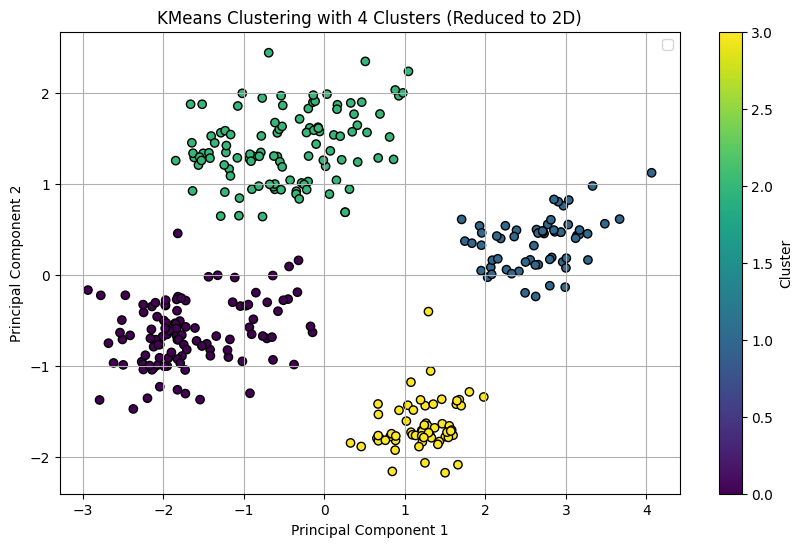

In [26]:
X_pca = reduce_to_2D(X)
draw2Dgraph(X_pca, labels, 'KMeans')

### Clustering with AHC (Agglomerative Hierarchical Clustering)

In [27]:
from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=4, linkage='ward')
y_agg = agg_clustering.fit_predict(X)

In [28]:
count_cluster_lengths(y_agg)

{'Cluster': [1, 2, 3, 4], 'Count': array([108,  62, 111,  61])}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


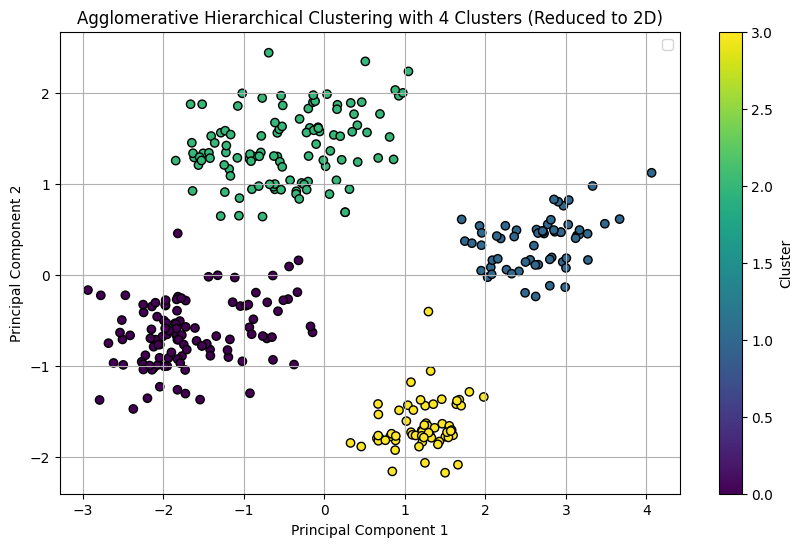

In [29]:
X_pca = reduce_to_2D(X)
draw2Dgraph(X_pca, labels, 'Agglomerative Hierarchical')